# Image Text Recognition

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import os 
import cv2
from datetime import datetime
import keras
import random
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D,Bidirectional
from keras.layers import AveragePooling2D, Flatten, Activation
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers.merge import add,concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers.recurrent import LSTM,GRU
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
C:\Users\saksham garg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\saksham garg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\saksham garg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\saksham garg\anaconda3\lib\site-packages\tensorflo

### 1. Data Loading

**Sampled_data_100.csv** file contains 100 Images sampled from Synth Text Test Data for Pipeline Implementation

In [2]:
test_data=pd.read_csv('test_data.csv')

In [3]:
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)
print(test_data.shape)

(15000, 2)


In [4]:
test_data.head()

,ImageName,Labels
0,mnt/ramdisk/max/90kDICT32px/3000/7/182_slinkin...,SLINKING
1,mnt/ramdisk/max/90kDICT32px/3000/7/181_REMODEL...,REMODELERS
2,mnt/ramdisk/max/90kDICT32px/3000/7/180_Chronog...,CHRONOGRAPHS
3,mnt/ramdisk/max/90kDICT32px/3000/7/179_Impeach...,IMPEACHING
4,mnt/ramdisk/max/90kDICT32px/3000/7/177_Loots_4...,LOOTS


### 2. Utility Functions

In [5]:
#Letters present in the Label Text
letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

**Integer Labels to Text Label Converter**

Converts a list of integers to corresponding characters and combines them as a string 

In [6]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

**Best Path Decoding**

In [7]:

def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 48, 37)
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

### 3. Model Parameters

In [8]:
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=64
max_length=15 # considering max length of ground truths labels to be 15

### 4. Model Architecture

In [9]:
def model_create(drop_out_rate=0.35):
    """
    Builds the model which takes input as images which is used for prediction and returns the Output Matrix 
    of of dimesnions 48x37 where 48 is the number of time-steps of RNN and 37 is the length of letters 
    + 1 character for ctc blank
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    return Model(inputs=[model_input], outputs=y_pred)

### 5. Image Prediction Pipeline

In [10]:
def test_data_single_image_Prediction(model,test_img_path):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start=datetime.now()
    
    test_img=cv2.imread(test_img_path)
    test_img_resized=cv2.resize(test_img,(170,32))
    test_image=test_img_resized[:,:,1]
    test_image=test_image.T 
    test_image=np.expand_dims(test_image,axis=-1)
    test_image=np.expand_dims(test_image, axis=0)
    test_image=test_image/255
    model_output=model.predict(test_image)
    predicted_output=decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ",datetime.now()-start)    

### 6. Loading Best Model 

In [11]:
model=model_create()

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 170, 32, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 170, 32, 64)       640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 170, 32, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 170, 32, 64)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 85, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 85, 16, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 85, 16, 128)       512 

The Best Weights for the Model are stored in BestLSTMModelWeights Folder, loading the stored best weights for Model 1 for prediction

In [13]:
model.load_weights('Best_Img_recog_LSTM_Adam_model_run_weights2.h5')

### 7. Single Image Prediction

In [14]:
test_image_1='images/.jpg'

In [15]:
Image(test_image_1)

FileNotFoundError: No such file or directory: 'images/.jpg'

FileNotFoundError: No such file or directory: 'images/.jpg'

<IPython.core.display.Image object>

In [16]:
test_data_single_image_Prediction(model,test_image_1)

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [26]:
test_image_2='Test_Data/101.jpg'

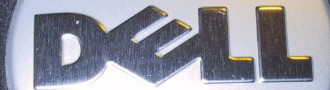

In [27]:
Image(test_image_2)

In [28]:
test_data_single_image_Prediction(model,test_image_2)

Predicted Text in the Image:  DLL
Time Taken for Processing:  0:00:00.059454


In [29]:

test_image_3='Test_Data/533_BUMPIER.jpg'

In [30]:
Image(test_image_3)

In [31]:

test_data_single_image_Prediction(model,test_image_3)

Predicted Text in the Image:  BUMPIER
Time Taken for Processing:  0:00:00.067119
